# Hands-on `jaxparrow`

The aim of this notebook is to illustrate how `jaxparrow` can be employed to derive geostrophic **and cyclogeostrophic** currents on a C-grid from Sea Surface Height (SSH) observations.  
The demo focuses on the **Alboran Sea**, a highly energetic area of the Mediterranean Sea ([Ioannou et al. 2019](https://doi.org/10.1029/2019JC015031)).

We use the European Seas Gridded L4 Sea Surface Heights And Derived Variables Reprocessed dataset ([description](https://data.marine.copernicus.eu/product/SEALEVEL_EUR_PHY_L4_MY_008_068/description), [reference](https://doi.org/10.48670/moi-00141)).  
This product provides daily average of SSH, and geostrophic currents, on a rectilinear A-grid, with a spatial resolution of 1/8°.

We need to install some dependencies first:

In [1]:
!pip install ipympl matplotlib cartopy
!pip install copernicusmarine jaxparrow jaxtyping numpy xarray

%reload_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Accessing Duacs data

Copernicus Marine datasets can be accessed through the [Copernicus Marine Toolbox](https://help.marine.copernicus.eu/en/collections/4060068-copernicus-marine-toolbox) API.

In [2]:
import copernicusmarine as cm

The [API](https://help.marine.copernicus.eu/en/collections/5821001-python-library-api) allows to download subsets of the datasets by restricting the spatial and temporal domains, and the variables.

In [3]:
import numpy as np

spatial_extent = (-5.3538, -1.1883, 35.0707, 36.8415)  # spatial extent (lon0, lon1, lat0, lat1) of the Alboran Sea
temporal_slice = (np.datetime64("2019-01-01T00:00:00"), np.datetime64("2019-12-31T23:59:59"))  # we look at the 2019 data for our demo
variables = ["adt", "ugos", "vgos"]  # we retrieve SSH and geostrophic currents (for comparison) data

dataset_options = {
    "dataset_id": "cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
    "variables": variables,
    "minimum_longitude": spatial_extent[0],
    "maximum_longitude": spatial_extent[1],
    "minimum_latitude": spatial_extent[2],
    "maximum_latitude": spatial_extent[3],
    "start_datetime": temporal_slice[0],
    "end_datetime": temporal_slice[1]
}
duacs_ds = cm.open_dataset(**dataset_options)

Fetching catalog: 100%|██████████| 4/4 [00:15<00:00,  3.92s/it]


INFO - 2024-03-27T10:13:13Z - Dataset version was not specified, the latest one was selected: "202112"
INFO - 2024-03-27T10:13:13Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-03-27T10:13:15Z - Service was not specified, the default one was selected: "arco-time-series"


### Visualisation

Lets visualise how the SSH, and the magnitude of the geostrophic currents, evolve over the time period.

In [5]:
duacs_ds = duacs_ds.assign(uvgos=np.sqrt(duacs_ds.ugos ** 2 + duacs_ds.vgos ** 2))

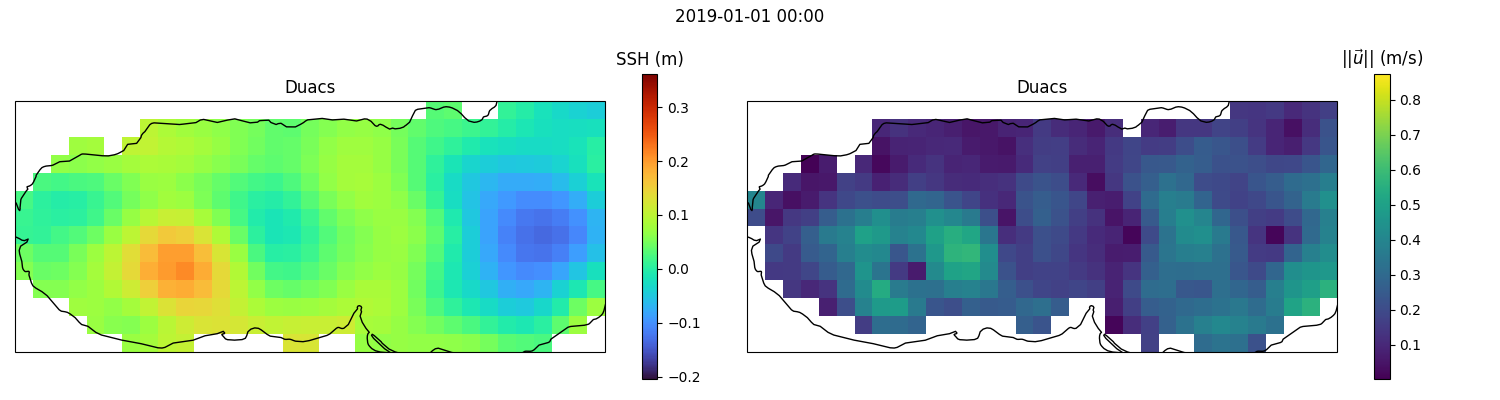

In [6]:
import matplotlib.pyplot as plt

from duacs_visualisation import AnimatedSSHCurrent
%matplotlib widget

anim = AnimatedSSHCurrent(duacs_ds, ("adt", "uvgos"), ("Duacs", "Duacs"))
plt.show()

## Geostrophic currents using `jaxparrow`

`jaxparrow` uses C-grids, following NEMO convention. U, V, and F points are automatically derived from the T points.

In [7]:
import jax.numpy as jnp  # we manipulate jax.Array

lat_t = jnp.ones((duacs_ds.latitude.size, duacs_ds.longitude.size)) * duacs_ds.latitude.data.reshape(-1, 1)
lon_t = jnp.ones((duacs_ds.latitude.size, duacs_ds.longitude.size)) * duacs_ds.longitude.data

The spatial domain covers sea and land, we derive tbe mask to exclude the land parts of the domain from the `adt` invalid values.

In [8]:
adt_t = jnp.asarray(duacs_ds.adt.data)
mask = ~(jnp.isfinite(adt_t))

And we compute the geostrophic currents using the `geostrophy` function.

Rather than looping over our time indices, we can vectorise the `geostrophy` function over the time axis and compute the geostrophic currents at every time point using the vectorise version.

In [9]:
import jax
import jaxparrow as jpw

vmap_geostrophy = jax.vmap(jpw.geostrophy, in_axes=(0, None, None, 0), out_axes=(0, 0, None, None, None, None))

ug_jpw_u, vg_jpw_v, lat_u, lon_u, lat_v, lon_v = vmap_geostrophy(adt_t, lat_t, lon_t, mask)

To visualise the results, we compute the magnitude of the velocity.

In [10]:
from jaxparrow.tools.kinematics import magnitude

uvg_jpw_t = jax.vmap(magnitude, in_axes=(0, 0))(ug_jpw_u, vg_jpw_v)

We store everything in an `xarray` `Dataset`.

In [11]:
import xarray as xr

gos_jpw_ds = xr.Dataset(
    {
        "adt": (["time", "latitude", "longitude"], adt_t),
        "ug": (["time", "latitude_u", "longitude_u"], ug_jpw_u),
        "vg": (["time", "latitude_v", "longitude_v"], vg_jpw_v),
        "uvg": (["time", "latitude", "longitude"], uvg_jpw_t)
    },
    coords={
        "time": duacs_ds.time,
        "latitude": duacs_ds.latitude, "longitude": duacs_ds.longitude, 
        "latitude_u": np.unique(lat_u).astype(np.float32), "longitude_u": np.unique(lon_u).astype(np.float32), 
        "latitude_v": np.unique(lat_v).astype(np.float32), "longitude_v": np.unique(lon_v).astype(np.float32)
    }
)

### Visualisation

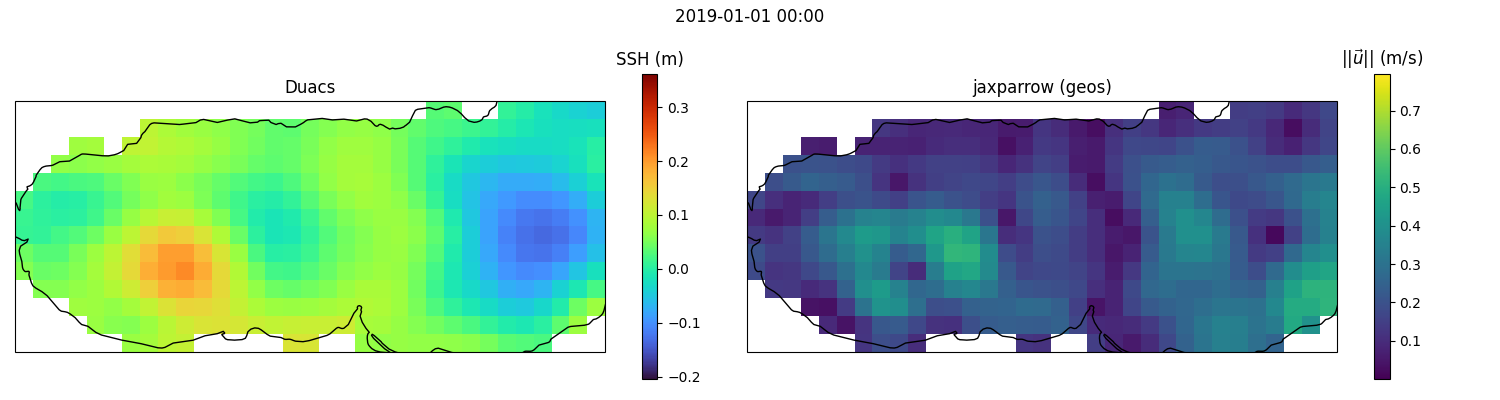

In [12]:
anim = AnimatedSSHCurrent(gos_jpw_ds, ("adt", "uvg"), ("Duacs", "jaxparrow (geos)"))
plt.show()

#### Geostrophic inter-comparison

For sanity check we can compare the two geostrophic reconstructions.

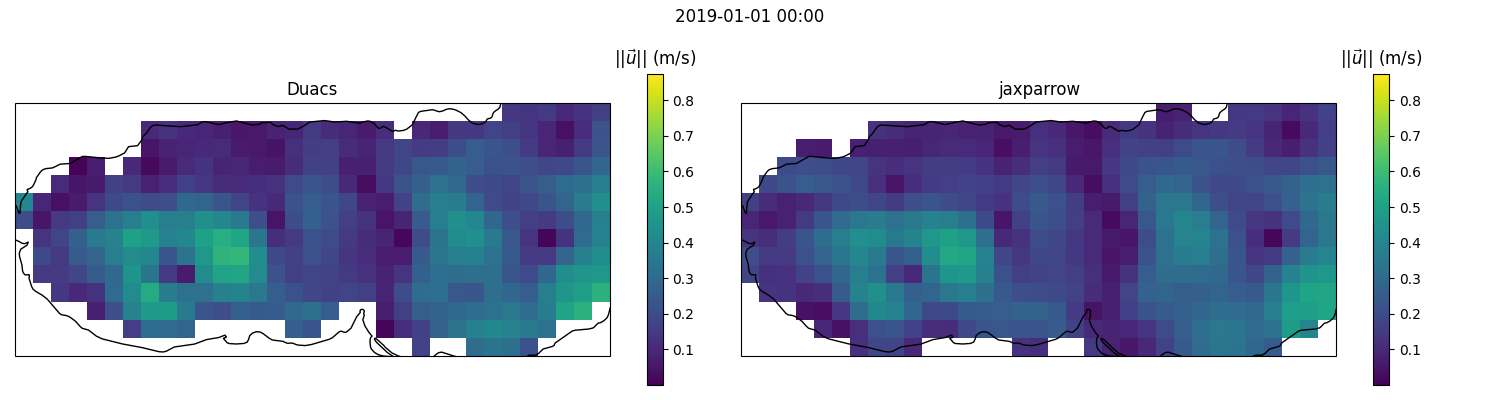

In [13]:
from duacs_visualisation import AnimatedCurrents

gos_ds = xr.Dataset(
    {
        "uvg": (["time", "latitude", "longitude"], duacs_ds.uvgos.data),
        "uvg_jpw": (["time", "latitude", "longitude"], uvg_jpw_t)
    },
    coords={
        "time": duacs_ds.time,
        "latitude": duacs_ds.latitude, "longitude": duacs_ds.longitude
    }
)

anim = AnimatedCurrents(gos_ds, ("uvg", "uvg_jpw"), ("Duacs", "jaxparrow"))
plt.show()

## Cyclogeostrophic currents using `jaxparrow`

Now, lets see the results of the variational inversion of the cyclogeostrophic currents.

In [14]:
vmap_cyclogeostrophy = jax.vmap(jpw.cyclogeostrophy, in_axes=(0, None, None, 0), out_axes=(0, 0, None, None, None, None))

uc_jpw_u, vc_jpw_v, lat_u, lon_u, lat_v, lon_v = vmap_cyclogeostrophy(adt_t, lat_t, lon_t, mask)

uvc_jpw_t = jax.vmap(magnitude, in_axes=(0, 0))(uc_jpw_u, vc_jpw_v)

/Users/bertrava/projects/jaxparrow/venv/lib/python3.9/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [15]:
cgos_jpw_ds = xr.Dataset(
    {
        "adt": (["time", "latitude", "longitude"], adt_t),
        "uc": (["time", "latitude_u", "longitude_u"], uc_jpw_u),
        "vc": (["time", "latitude_v", "longitude_v"], vc_jpw_v),
        "uvc": (["time", "latitude", "longitude"], uvc_jpw_t)
    },
    coords={
        "time": duacs_ds.time,
        "latitude": duacs_ds.latitude, "longitude": duacs_ds.longitude, 
        "latitude_u": np.unique(lat_u).astype(np.float32), "longitude_u": np.unique(lon_u).astype(np.float32), 
        "latitude_v": np.unique(lat_v).astype(np.float32), "longitude_v": np.unique(lon_v).astype(np.float32)
    }
)

### Visualisation

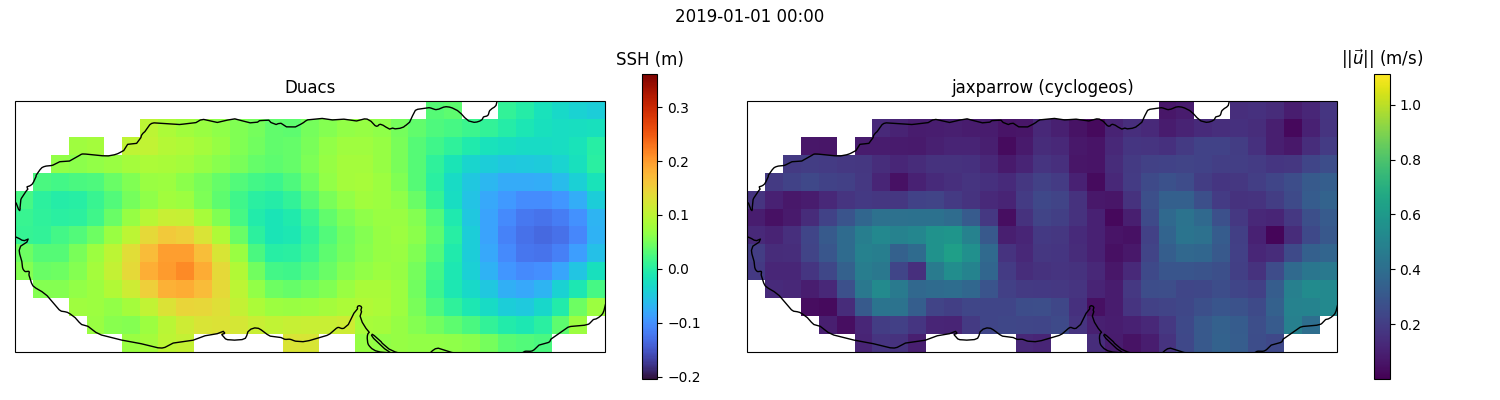

In [16]:
anim = AnimatedSSHCurrent(cgos_jpw_ds, ("adt", "uvc"), ("Duacs", "jaxparrow (cyclogeos)"))
plt.show()

#### Comparison with geostrophy

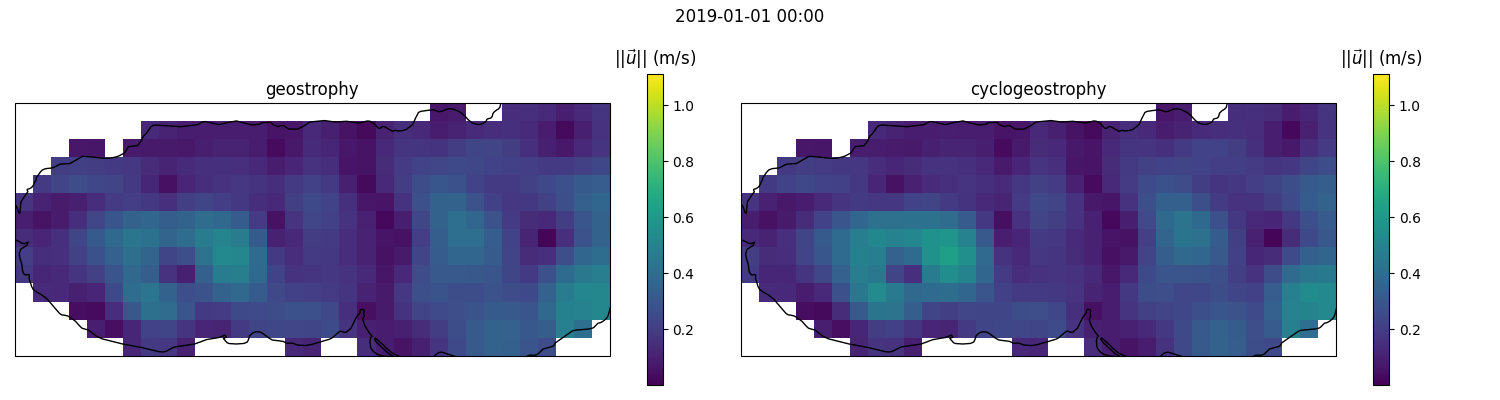

In [17]:
jpw_ds = xr.Dataset(
    {
        "uvg": (["time", "latitude", "longitude"], uvg_jpw_t),
        "uvc": (["time", "latitude", "longitude"], uvc_jpw_t)
    },
    coords={
        "time": duacs_ds.time,
        "latitude": duacs_ds.latitude, "longitude": duacs_ds.longitude
    }
)

anim = AnimatedCurrents(jpw_ds, ("uvg", "uvc"), ("geostrophy", "cyclogeostrophy"))
plt.show()